In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [2]:
from osu_util import read_osu_log, read_osu_log_multi, plot_osu

In [3]:
ls osu_log/bcast/

N16n576/  N1n36/    N2n72/    N32n1152/ N4n144/   N8n288/


In [4]:
ls osu_log/bcast/N2n72/run3/

intelmpi-efa/ intelmpi-tcp/ mpich3/       openmpi3/     openmpi4/


In [5]:
ls osu_log/bcast/N2n72/run3/openmpi4

bcast_algo4.log    bcast_algo7.log    bcast_default.log


In [6]:
ls osu_log/bcast/N2n72/run3/intelmpi-efa

bcast_algo10.log   bcast_algo8.log    bcast_default.log


In [7]:
def read_bcast_scaling(suffix, prefix='./osu_log/bcast/'):
    N_list = [1, 2, 4, 8, 16, 32]

    file_list = [prefix + 'N{0}n{1}'.format(N, N*36) + suffix for N in N_list]
    # print(file_list)
    
    df = read_osu_log_multi(file_list, [N*36 for N in N_list])
    return df

# Intel-MPI

In [8]:
df_impi_efa = read_bcast_scaling('/run3/intelmpi-efa/bcast_default.log')
df_impi_efa

,36,72,144,288,576,1152
size,,,,,,
1,0.91,30.14,20.70,20.33,20.93,43.12
2,0.91,30.35,20.43,20.32,21.30,43.77
4,1.77,30.67,20.82,20.50,21.23,44.54
8,1.77,30.64,20.49,20.58,20.98,43.84
16,1.82,30.62,20.80,20.66,20.76,43.62
32,1.58,30.55,20.47,20.44,20.99,43.46
64,1.81,30.31,20.82,20.58,20.88,44.81
128,1.53,30.31,20.51,20.52,20.62,44.74
256,1.94,30.52,21.16,20.87,20.74,45.01


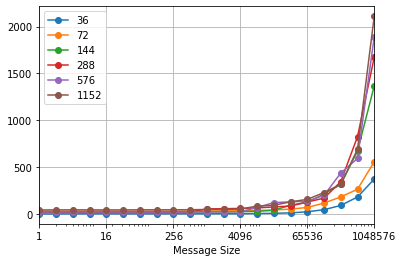

In [9]:
plot_osu(df_impi_efa)

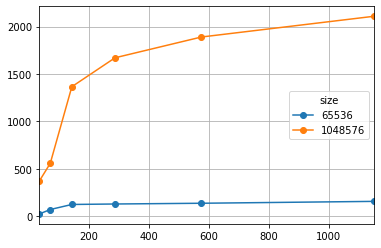

In [10]:
df_impi_efa.loc[[65536, 1048576]].T.plot(marker='o', grid=True)

In [11]:
df_impi_tcp = read_bcast_scaling('/run3/intelmpi-tcp/bcast_default.log')
df_impi_tcp

,36,72,144,288,576,1152
size,,,,,,
1,0.91,30.94,34.06,36.45,39.16,111.60
2,0.90,29.90,32.86,35.21,35.03,110.59
4,1.85,30.98,34.20,35.71,36.38,111.19
8,1.84,30.82,34.31,35.87,36.44,111.74
16,1.86,30.90,33.07,35.99,36.58,111.93
32,1.62,31.62,33.30,36.56,37.67,113.95
64,1.66,31.53,34.76,36.18,37.47,112.71
128,1.53,31.74,35.00,36.73,38.92,113.35
256,1.96,46.93,33.91,36.21,33.88,105.97


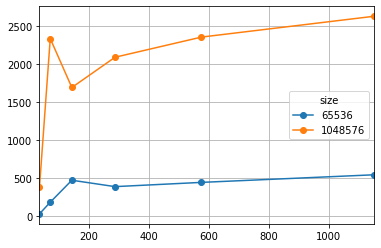

In [12]:
df_impi_tcp.loc[[65536, 1048576]].T.plot(marker='o', grid=True)

# OpenMPI

In [13]:
df_ompi3 = read_bcast_scaling('/run3/openmpi3/bcast_default.log')
df_ompi3

,36,72,144,288,576,1152
size,,,,,,
1,1.69,42.75,66.79,138.65,123.61,140.30
2,1.70,41.55,66.82,100.94,128.52,145.80
4,1.70,42.70,66.00,130.25,122.48,148.17
8,1.71,42.91,66.97,102.60,128.64,151.19
16,1.80,43.02,66.12,101.92,133.42,151.58
32,1.80,44.55,69.10,101.85,132.83,151.17
64,2.15,44.14,72.72,122.96,134.30,155.87
128,2.25,44.23,72.90,104.69,135.48,301.27
256,2.37,45.20,73.10,104.45,134.84,157.90


In [14]:
df_ompi4 = read_bcast_scaling('/run3/openmpi4/bcast_default.log')
df_ompi4

,36,72,144,288,576,1152
size,,,,,,
1,1.53,44.96,67.29,92.02,122.02,145.55
2,1.54,46.49,69.81,92.93,121.97,152.56
4,1.53,46.33,68.86,92.97,123.94,155.23
8,1.55,47.68,70.19,94.69,131.83,151.72
16,1.63,46.61,69.00,93.57,126.46,150.49
32,1.67,47.17,70.33,147.75,133.02,151.37
64,1.96,47.56,70.22,102.59,129.21,153.67
128,2.17,47.13,71.22,102.96,133.76,156.04
256,2.42,47.90,70.69,125.19,129.39,155.78


In [15]:
df_ompi4_algo7 = read_bcast_scaling('/run3/openmpi4/bcast_algo7.log')
df_ompi4_algo7 

,36,72,144,288,576,1152
size,,,,,,
1,1.56,44.14,61.95,56.48,90.04,103.17
2,1.55,44.31,61.26,54.68,90.31,85.51
4,1.55,43.75,61.92,249.43,90.63,235.62
8,1.59,44.59,61.64,57.99,90.86,85.81
16,1.70,48.82,60.83,57.92,90.31,86.59
32,1.73,48.65,62.13,55.70,90.78,87.31
64,2.14,49.43,63.45,58.16,93.13,89.61
128,2.38,49.57,63.77,58.04,93.21,93.66
256,2.83,49.74,63.94,59.40,94.74,88.19


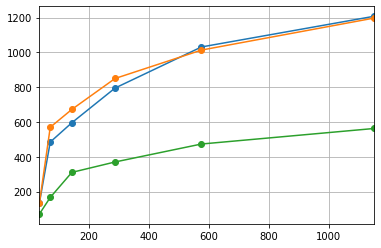

In [16]:
for df in [df_ompi3, df_ompi4, df_ompi4_algo7]:
    df.loc[65536].plot(marker='o', grid=True)

# MPICH

In [17]:
df_mpich = read_bcast_scaling('/run3/mpich3/bcast_default.log')
df_mpich

,36,72,144,288,576,1152
size,,,,,,
1,1.18,32.09,40.88,44.27,55.96,66.22
2,1.18,33.74,40.06,41.02,52.61,63.77
4,1.19,33.68,40.82,41.74,53.57,64.79
8,1.21,33.59,40.99,43.04,52.67,83.73
16,1.27,33.27,40.87,42.86,57.30,60.87
32,1.31,33.70,42.86,48.30,56.14,64.23
64,1.33,33.84,42.29,45.97,56.83,62.64
128,1.46,33.81,43.03,45.67,54.60,61.80
256,1.58,34.46,43.54,46.06,56.51,62.99


# Put all together

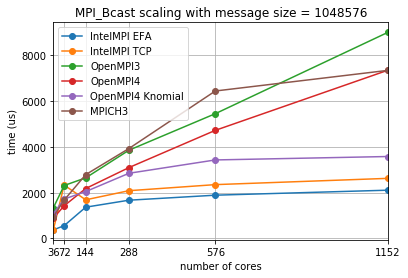

In [18]:
df_mapping = {
    'IntelMPI EFA': df_impi_efa, 
    'IntelMPI TCP': df_impi_tcp, 
    'OpenMPI3': df_ompi3, 
    'OpenMPI4': df_ompi4, 
    'OpenMPI4 Knomial': df_ompi4_algo7,
    'MPICH3': df_mpich
}

# message = 65536
message = 1048576

for name, df in df_mapping.items():
    df.loc[message].plot(marker='o', grid=True, label=name)
    
plt.xticks(df.columns)
plt.ylabel('time (us)')
plt.xlabel('number of cores')

plt.legend()

plt.title('MPI_Bcast scaling with message size = {}'.format(message))
plt.savefig('bcast_scaling.png', dpi=144, bbox_inches='tight')